# Imports

In [1]:
import sys
import numpy as np
from sympy import symbols, Piecewise, lambdify, integrate
from tqdm.notebook import trange, tqdm
import matplotlib

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
from src.convolution.numerical import (
    step_function,
    step_functions,
    function_norm,
    self_convolution_integrand,
    self_convolution,
)
from src.spectrum import LinealEnergySpectrum, SpectrumValueType, SpectrumData
from src.paths import project_dir

In [3]:
!python -V

Python 3.9.8


# Step function

In [4]:
x = symbols("x")
piecewise_function = Piecewise((0.5, (x > 0) & (x < 2)), (0, True))

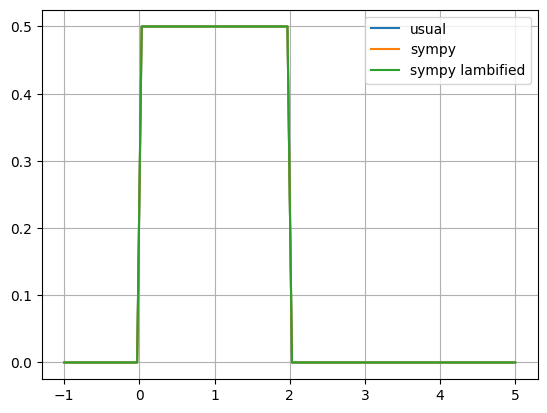

In [5]:
xvalues = np.linspace(start=-1, stop=5, num=100)
fig, ax = plt.subplots()
ax.plot(xvalues, step_functions(xvalues), label="usual")
ax.plot(
    xvalues, [piecewise_function.subs(x, xvalue) for xvalue in xvalues], label="sympy"
)
ax.plot(
    xvalues, lambdify(x, piecewise_function, "numpy")(xvalues), label="sympy lambified"
)
ax.grid()
ax.legend();

## Norm

In [6]:
function_norm(step_function, lower_limit=-1, upper_limit=3)

1.0

In [7]:
function_norm(lambdify(x, piecewise_function, "numpy"), lower_limit=-1, upper_limit=3)

1.0

In [8]:
integral_result = integrate(piecewise_function, (x, -np.inf, np.inf))
integral_result

1.00000000000000

## Convolution

In [9]:
piecewise_function

Piecewise((0.5, (x > 0) & (x < 2)), (0, True))

In [10]:
t = symbols("t")
f1_function = piecewise_function

# f(t) * f(x-t)
convolution_integrand_f1 = f1_function.subs(x, t) * f1_function.subs(x, x - t)
convolution_integrand_f1

Piecewise((0.5, (t > 0) & (t < 2)), (0, True))*Piecewise((0.5, (t - x > -2) & (t - x < 0)), (0, True))

In [11]:
convolution_integrand_f1.subs(x, 1).subs(t, 0.5)

0.250000000000000

In [12]:
# Define the convolution integrand function
f2_function = integrate(
    f1_function.subs(x, t) * f1_function.subs(x, x - t), (t, -np.inf, np.inf)
)
f2_function

-0.25*Max(0, x - 2) + 0.25*Max(0, x - 2, Min(2, x))

In [13]:
# plotting limits
y_values = np.linspace(start=-2, stop=2, num=100)
# tricks needed to make the integral converge
step_function_args = (1, -0.5, 0.5, sys.float_info.min)
expected_conv_domain = (-1, 1)
convolution_integration_limits = (-100, 100)
integral_kwargs = {"limit": 2000, "points": np.linspace(*expected_conv_domain, 100)}
convolution_values = np.array(
    [
        self_convolution(
            step_function,
            lower_limit=convolution_integration_limits[0],
            upper_limit=convolution_integration_limits[1],
            kwargs=integral_kwargs,
        )(y=y, integrand_args=step_function_args)[0]
        for y in y_values
    ]
)

In [14]:
# tricks needed to make the integral converge
step_function_args = (1.0, 0.0, 2.0, sys.float_info.min)
expected_conv_domain = (0, 4)
convolution_integration_limits = (-100, 100)
integral_kwargs = {"limit": 2000, "points": np.linspace(*expected_conv_domain, 100)}
convolution_values = np.array(
    [
        self_convolution(
            step_function,
            lower_limit=convolution_integration_limits[0],
            upper_limit=convolution_integration_limits[1],
            kwargs=integral_kwargs,
        )(y=y, integrand_args=step_function_args)[0]
        for y in xvalues
    ]
)

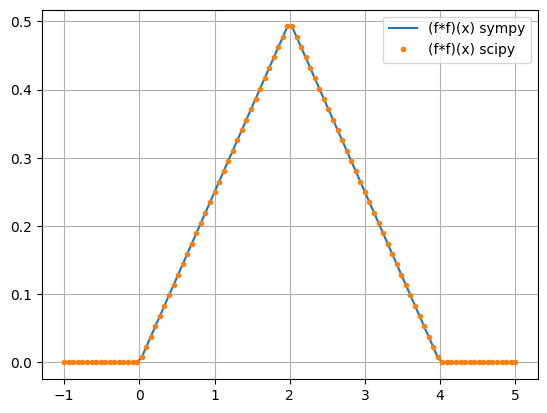

In [15]:
fig, ax = plt.subplots()
# ax.plot(xvalues, step_functions(xvalues), label="usual")
ax.plot(
    xvalues, [f2_function.subs(x, xvalue) for xvalue in xvalues], label="(f*f)(x) sympy"
)
ax.plot(xvalues, convolution_values, ".", label="(f*f)(x) scipy")
ax.grid()
ax.legend();

### Checking first moments

In [16]:
# from src.helpers import first_moment, first_moment2
# f1_1st_moment = first_moment(bin_centers=xvalues, bin_values=step_functions(xvalues, *step_function_args))
# f2_1st_moment = first_moment(bin_centers=xvalues, bin_values=convolution_values)
# bin_edges = np.append(xvalues[0] - (xvalues[1] - xvalues[0]) / 2, xvalues + (xvalues[1] - xvalues[0]) / 2)
# f2_1st_moment2 = first_moment2(bin_edges=bin_edges, bin_values=step_functions(xvalues, *step_function_args))
# print(f"f1_1st_moment={f1_1st_moment:2.2f}, f2_1st_moment={f2_1st_moment:2.2f}, f2_1st_moment2={f2_1st_moment2:2.2f}")
# #print(f"f1_1st_moment={f1_1st_moment:2.2f}, f2_1st_moment={f2_1st_moment:2.2f}")

In [17]:
f1_1st_moment = integrate(f1_function.subs(x, t) * t, (t, -np.inf, np.inf))
f2_1st_moment = integrate(f2_function.subs(x, t) * t, (t, -np.inf, np.inf))
print(f"f1_1st_moment={f1_1st_moment:2.2f}, f2_1st_moment={f2_1st_moment:2.2f}")

f1_1st_moment=1.00, f2_1st_moment=2.00


# Spectrum

## Data

In [18]:
spectrum = LinealEnergySpectrum.from_csv(
    project_dir / "data" / "interim" / "Xrays_25keV_1um_yfy.csv",
    delimiter=",",
    value_type=SpectrumValueType.freq_times_bin_centers,
)
spectrum.norm

0.9938634018608192

In [19]:
spectrum.yfy.min(), spectrum.yfy.max()

(-0.0008956877263814889, 0.4982137261046694)

In [20]:
spectrum.yfy.clip(min=0).min(), spectrum.yfy.clip(min=0).max()

(0.0, 0.4982137261046694)

In [21]:
spectrum_clipped = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=spectrum.y, bin_values_freq_times_x=spectrum.yfy.clip(min=0)
    )
)
spectrum_clipped.yfy.min(), spectrum_clipped.yfy.max()

(0.0, 0.4982137261046694)

In [22]:
xvalues = np.geomspace(
    start=spectrum_clipped.data.bin_edges[0] / 2,
    stop=spectrum_clipped.data.bin_edges[-1] * 2,
    num=1000,
)
values_fy = spectrum_clipped.data.bin_values(
    xvalues, spectrum_value_type=SpectrumValueType.fy
)
values_yfy = spectrum_clipped.data.bin_values(
    xvalues, spectrum_value_type=SpectrumValueType.yfy
)
values_ydy = spectrum_clipped.data.bin_values(
    xvalues, spectrum_value_type=SpectrumValueType.ydy
)

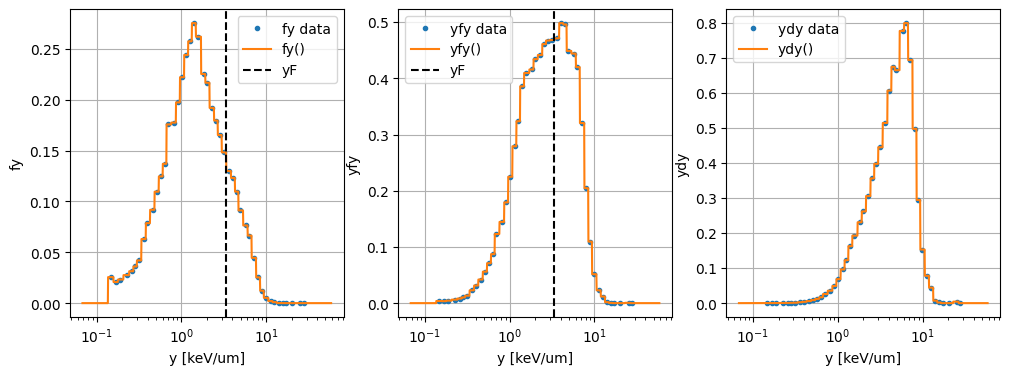

In [23]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, ".", label="fy data")
ax[0].plot(xvalues, values_fy, label="fy()")
ax[0].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, ".", label="yfy data")
ax[1].plot(xvalues, values_yfy, label="yfy()")
ax[1].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, ".", label="ydy data")
ax[2].plot(xvalues, values_ydy, label="ydy()")
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

In [24]:
expressions = spectrum_clipped.fy.tolist()
expressions.append(0.0)  # Default value outside the defined intervals
expressions[-3:]

[2.1734555327931618e-05, 0.0, 0.0]

In [25]:
conditions = [
    (x >= spectrum_clipped.data.bin_edges[i])
    & (x < spectrum_clipped.data.bin_edges[i + 1])
    for i in range(spectrum_clipped.data.num_bins)
]
conditions.append(True)  # Default value outside the defined intervals
conditions[-3:]

[(x >= 22.862169803749) & (x < 26.6756427753102),
 (x >= 26.6756427753102) & (x < 29.2601205107955),
 True]

In [26]:
list(zip(expressions, conditions))[-3:]

[(2.1734555327931618e-05, (x >= 22.862169803749) & (x < 26.6756427753102)),
 (0.0, (x >= 26.6756427753102) & (x < 29.2601205107955)),
 (0.0, True)]

In [27]:
# Define the piecewise function based on conditions and expressions
spectrum_f1_function = Piecewise(*tuple(zip(expressions, conditions)))
spectrum_f1_function

Piecewise((0.0255758864824328, (x >= 0.136304325884623) & (x < 0.158166654174488)), (0.0207176674612319, (x >= 0.158166654174488) & (x < 0.178995555979229)), (0.0232111163498623, (x >= 0.178995555979229) & (x < 0.207505861310195)), (0.0275314032724379, (x >= 0.207505861310195) & (x < 0.242893004368486)), (0.0313670302845602, (x >= 0.242893004368486) & (x < 0.270898800462973)), (0.036045757565086, (x >= 0.270898800462973) & (x < 0.298627964074119)), (0.0419918226119867, (x >= 0.298627964074119) & (x < 0.338439741368576)), (0.0629969884818269, (x >= 0.338439741368576) & (x < 0.380079742286561)), (0.078647843964825, (x >= 0.380079742286561) & (x < 0.427869502272797)), (0.0917962100242395, (x >= 0.427869502272797) & (x < 0.483947731230387)), (0.109594075789807, (x >= 0.483947731230387) & (x < 0.540260348328834)), (0.124603461849899, (x >= 0.540260348328834) & (x < 0.603095192787552)), (0.137015975612754, (x >= 0.603095192787552) & (x < 0.668022434061255)), (0.17575192387162, (x >= 0.668022

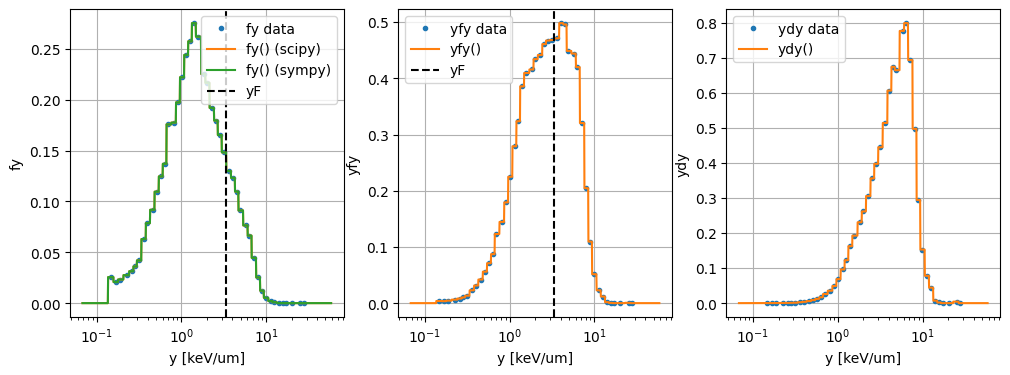

In [28]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, ".", label="fy data")
ax[0].plot(xvalues, values_fy, label="fy() (scipy)")
ax[0].plot(
    xvalues, lambdify(x, spectrum_f1_function, "numpy")(xvalues), label="fy() (sympy)"
)
ax[0].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, ".", label="yfy data")
ax[1].plot(xvalues, values_yfy, label="yfy()")
ax[1].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, ".", label="ydy data")
ax[2].plot(xvalues, values_ydy, label="ydy()")
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## Normalization

In [29]:
pdf_function = lambda xv: spectrum_clipped.data.bin_value(
    xv, spectrum_value_type=SpectrumValueType.fy
)
function_norm(
    pdf_function,
    lower_limit=spectrum_clipped.data.bin_edges[0],
    upper_limit=spectrum_clipped.data.bin_edges[-1],
)

c:\users\legion\workspace\microdosimetric_spectra_folding\src\convolution\numerical.py:36: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  I = quad(func=func, a=lower_limit, b=upper_limit, args=args, **kwargs)


0.9870827697855141

In [30]:
pdf_function = lambda xv: spectrum_clipped.data.bin_value(
    xv, spectrum_value_type=SpectrumValueType.fy
)
function_norm(pdf_function)

0.9937516998520008

In [31]:
function_norm(spectrum_clipped.data.bin_value, args=(SpectrumValueType.fy,))

0.9937516998520008

In [32]:
integral_result = integrate(spectrum_f1_function, (x, -np.inf, np.inf))
integral_result

0.994076466439742

## yF

In [33]:
# from src.helpers import first_moment
# f1_1st_moment = first_moment(bin_centers=spectrum_clipped.y, bin_values=spectrum_clipped.fy)
# f1_1st_moment

In [34]:
yF_sympy = integrate(x * spectrum_f1_function, (x, -np.inf, np.inf))
yF_sympy

3.30164594288118

In [35]:
# f1_1st_moment2 = first_moment2(bin_edges=spectrum_clipped.bin_edges, bin_values=spectrum_clipped.fy)
# f1_1st_moment2

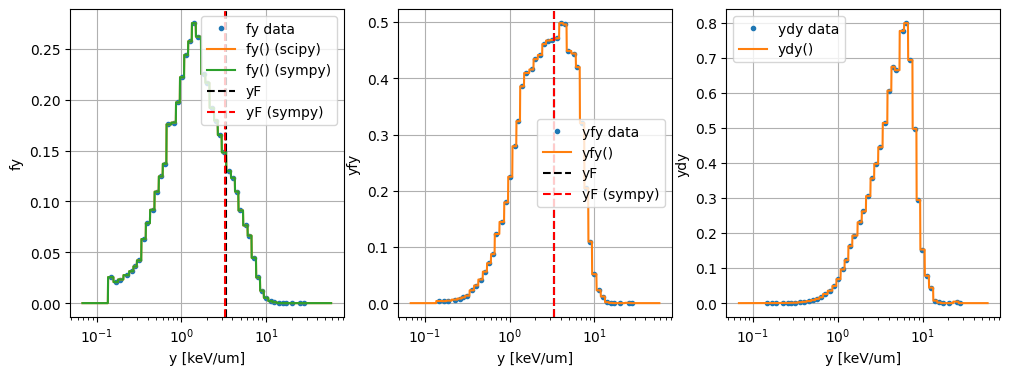

In [36]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, ".", label="fy data")
ax[0].plot(xvalues, values_fy, label="fy() (scipy)")
ax[0].plot(
    xvalues, lambdify(x, spectrum_f1_function, "numpy")(xvalues), label="fy() (sympy)"
)
ax[0].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[0].axvline(yF_sympy, color="r", linestyle="--", label="yF (sympy)")
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, ".", label="yfy data")
ax[1].plot(xvalues, values_yfy, label="yfy()")
ax[1].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[1].axvline(yF_sympy, color="r", linestyle="--", label="yF (sympy)")
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, ".", label="ydy data")
ax[2].plot(xvalues, values_ydy, label="ydy()")
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

## Folding

### Single values

In [37]:
f1_function = lambda xv: spectrum_clipped.data.bin_value(
    xv, spectrum_value_type=SpectrumValueType.fy
)
f1_function(2)

0.21672449170916908

In [38]:
self_convolution(
    f1_function,
    lower_limit=convolution_integration_limits[0],
    upper_limit=convolution_integration_limits[1],
    kwargs=integral_kwargs,
)(30)

(1.50549185434693e-05, 5.829720734590419e-09)

In [39]:
spectrum_clipped.data.bin_edges[0], spectrum_clipped.data.bin_edges[-1]

(0.13630432588462332, 29.260120510795517)

In [40]:
x, t

(x, t)

In [41]:
integrate(
    spectrum_f1_function,
    (x, spectrum_clipped.data.bin_edges[0], spectrum_clipped.data.bin_edges[-1]),
)

0.994076466439742

In [42]:
xeval = 4
integral_eval = 0
for bin_no in trange(spectrum_clipped.data.num_bins):
    current_value = integrate(
        spectrum_f1_function.subs(x, xeval - t),
        (
            t,
            spectrum_clipped.data.bin_edges[bin_no],
            spectrum_clipped.data.bin_edges[bin_no + 1],
        ),
    )
    integral_eval += current_value * spectrum_clipped.fy[bin_no]
    # print(f"bin_no={bin_no}, bin_edges={spectrum_clipped.bin_edges[bin_no:bin_no+2]}, current_value={current_value}, integral_eval={integral_eval}")

  0%|          | 0/45 [00:00<?, ?it/s]

In [43]:
xeval = 4
integral_eval = 0
indefinite_int = integrate(spectrum_f1_function.subs(x, xeval - t), t)
for bin_no in range(spectrum_clipped.data.num_bins):
    current_value = indefinite_int.evalf(
        subs={t: spectrum_clipped.data.bin_edges[bin_no + 1]}
    ) - indefinite_int.evalf(subs={t: spectrum_clipped.data.bin_edges[bin_no]})
    integral_eval += current_value * spectrum_clipped.fy[bin_no]
    print(
        f"bin_no={bin_no}, bin_edges={spectrum_clipped.data.bin_edges[bin_no:bin_no+2]}, current_value={current_value}, integral_eval={integral_eval}"
    )

bin_no=0, bin_edges=[0.13630433 0.15816665], current_value=0.00269222018930138, integral_eval=0.0000688559179472857
bin_no=1, bin_edges=[0.15816665 0.17899556], current_value=0.00266651307160692, integral_eval=0.000124099849045866
bin_no=2, bin_edges=[0.17899556 0.20750586], current_value=0.00370434960298216, integral_eval=0.000210081938681251
bin_no=3, bin_edges=[0.20750586 0.242893  ], current_value=0.00459785848720023, integral_eval=0.000336667434881962
bin_no=4, bin_edges=[0.242893  0.2708988], current_value=0.00363879861823618, integral_eval=0.000450805741339592
bin_no=5, bin_edges=[0.2708988  0.29862796], current_value=0.00360285570503555, integral_eval=0.000580673404625290
bin_no=6, bin_edges=[0.29862796 0.33843974], current_value=0.00517275208745505, integral_eval=0.000797886692697487
bin_no=7, bin_edges=[0.33843974 0.38007974], current_value=0.00541029354396921, integral_eval=0.00113871889277022
bin_no=8, bin_edges=[0.38007974 0.4278695 ], current_value=0.00620933295440179, in

In [44]:
# xeval = 4
# integral_eval = 0
# indefinite_int_full = integrate(spectrum_f1_function.subs(x, t), t)
# for bin_no in range(spectrum_clipped.num_bins):
#     current_value = indefinite_int_full.evalf(subs={t: xeval-spectrum_clipped.bin_edges[bin_no]}) - indefinite_int_full.evalf(subs={t: xeval-spectrum_clipped.bin_edges[bin_no+1]})
#     integral_eval += current_value * spectrum_clipped.bin_values_fy[bin_no]
#     print(f"\t xeval = {xeval} upper limit = {xval-spectrum_clipped.bin_edges[bin_no]}, lower limit = {xval-spectrum_clipped.bin_edges[bin_no+1]}")
#     print(f"bin_no={bin_no}, bin_edges={spectrum_clipped.bin_edges[bin_no:bin_no+2]}, current_value={current_value}, integral_eval={integral_eval}")

In [45]:
def sympy_conv(xeval: float) -> float:
    integral_eval = 0
    indefinite_int = integrate(spectrum_f1_function.subs(x, xeval - t), t)
    for bin_no in range(spectrum_clipped.data.num_bins):
        current_value = indefinite_int.evalf(
            subs={t: spectrum_clipped.data.bin_edges[bin_no + 1]}
        ) - indefinite_int.evalf(subs={t: spectrum_clipped.data.bin_edges[bin_no]})
        integral_eval += current_value * spectrum_clipped.fy[bin_no]
    return integral_eval

In [46]:
from typing import List


def sympy_conv_full(xeval: List[float]) -> List[float]:
    indefinite_int_full = integrate(spectrum_f1_function.subs(x, t), t)
    integral_eval = []
    for xeval_current in xeval:
        integral_eval_current = 0
        for bin_no in range(spectrum_clipped.data.num_bins):
            current_value = indefinite_int_full.evalf(
                subs={t: xeval_current - spectrum_clipped.data.bin_edges[bin_no]}
            ) - indefinite_int_full.evalf(
                subs={t: xeval_current - spectrum_clipped.data.bin_edges[bin_no + 1]}
            )
            integral_eval_current += current_value * spectrum_clipped.fy[bin_no]
        integral_eval.append(integral_eval_current)
    return integral_eval

In [47]:
sympy_conv(14)

0.0116320416027285

In [48]:
sympy_conv_full([14])

[0.0116320416027285]

In [49]:
xeval = 4
indefinite_int = integrate(spectrum_f1_function.subs(x, xeval - t), t)

In [50]:
indefinite_int.evalf(
    subs={t: spectrum_clipped.data.bin_edges[1]}
) - indefinite_int.evalf(subs={t: spectrum_clipped.data.bin_edges[0]})

0.00269222018930138

In [51]:
integrate(
    spectrum_f1_function.subs(x, xeval - t),
    (t, spectrum_clipped.data.bin_edges[0], spectrum_clipped.data.bin_edges[1]),
)

0.00269222018930138

In [52]:
sympy_conv(1)

0.00545213941832270

### Domain and plotting

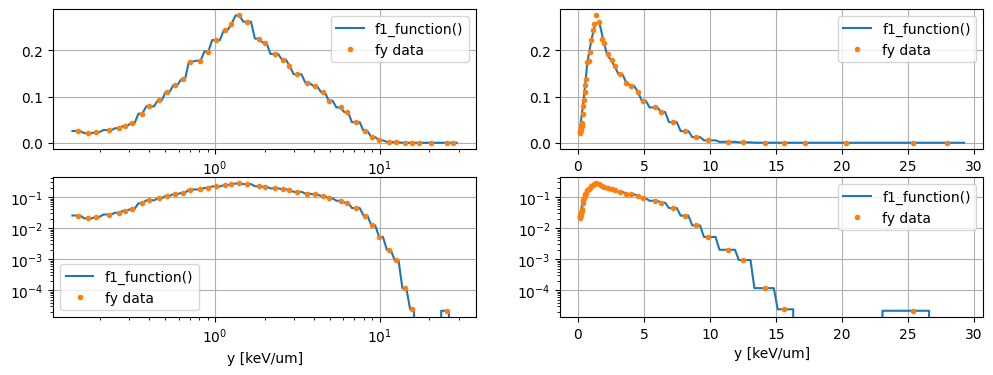

In [53]:
xvalues_geom = np.geomspace(
    start=spectrum_clipped.data.bin_edges[0],
    stop=spectrum_clipped.data.bin_edges[-1],
    num=100,
)
xvalues_lin = np.linspace(
    start=spectrum_clipped.data.bin_edges[0],
    stop=spectrum_clipped.data.bin_edges[-1],
    num=100,
)
yvalues_geom = f1_function(xvalues_geom)
yvalues_lin = f1_function(xvalues_lin)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(12, 4))
ax[0][0].plot(xvalues_geom, yvalues_geom, label="f1_function()")
ax[0][0].set_xscale("log")
ax[0][1].plot(xvalues_lin, yvalues_lin, label="f1_function()")
ax[1][0].plot(xvalues_geom, yvalues_geom, label="f1_function()")
ax[1][0].set_xscale("log")
ax[1][0].set_yscale("log")
ax[1][1].plot(xvalues_lin, yvalues_lin, label="f1_function()")
ax[1][1].set_yscale("log")
for a in ax.flatten():
    a.plot(spectrum_clipped.y, spectrum_clipped.fy, ".", label="fy data")
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()

In [54]:
expected_conv_domain = (
    spectrum_clipped.data.bin_edges[0] * 2,
    spectrum_clipped.data.bin_edges[-1] * 2.0,
)
xvalues_for_integration = np.geomspace(
    start=expected_conv_domain[0], stop=expected_conv_domain[1], num=40
)

convolution_integration_limits = (
    spectrum_clipped.data.bin_edges[0],
    spectrum_clipped.data.bin_edges[-1],
)
integral_kwargs = {
    "limit": 400,
    "points": np.geomspace(*convolution_integration_limits, 80),
}
f2_values = [
    self_convolution(
        f1_function,
        lower_limit=convolution_integration_limits[0],
        upper_limit=convolution_integration_limits[1],
        kwargs=integral_kwargs,
    )(y)
    for y in tqdm(xvalues_for_integration)
]

  0%|          | 0/40 [00:00<?, ?it/s]

c:\users\legion\workspace\microdosimetric_spectra_folding\src\convolution\numerical.py:75: IntegrationWarning: The maximum number of subdivisions (400) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  return quad(


In [55]:
xvalues_for_integration_sympy = np.geomspace(
    start=spectrum_clipped.data.bin_edges[0],
    stop=spectrum_clipped.data.bin_edges[-1] * 4,
    num=100,
)
f2_values_sympy = sympy_conv_full(xvalues_for_integration_sympy.tolist())

In [56]:
# f2_values_sympy = sympy_conv_full(xvalues_for_integration)
# for xval,yval, sval in zip(xvalues_for_integration, f2_values, f2_values_sympy):
#     print(xval, yval[0], sval)
#     #print(f"f2({xval:g})={yval[0]:g} (scipy={sympy_val:g})")

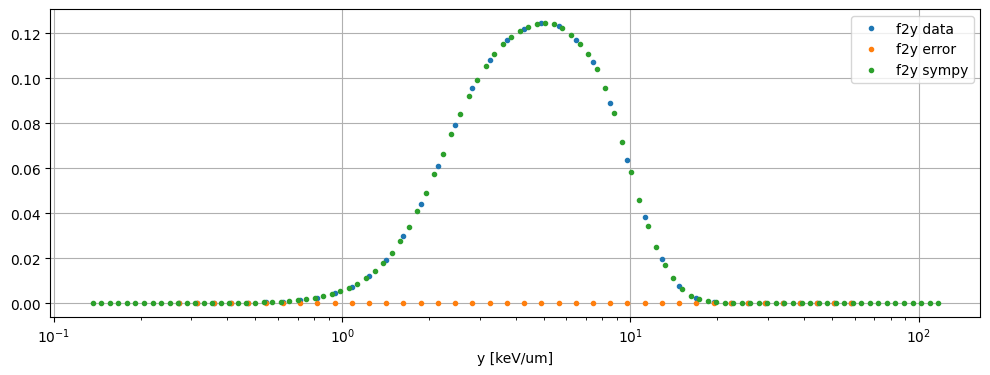

In [57]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
ax.plot(xvalues_for_integration, [item[0] for item in f2_values], ".", label="f2y data")
ax.plot(
    xvalues_for_integration, [item[1] for item in f2_values], ".", label="f2y error"
)
ax.plot(xvalues_for_integration_sympy, f2_values_sympy, ".", label="f2y sympy")
ax.grid()
ax.set_xlabel("y [keV/um]")
ax.legend()
ax.set_xscale("log")
# ax.set_yscale('log')

In [58]:
f2_spectrum = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=xvalues_for_integration,
        bin_values_freq=np.array([item[0] for item in f2_values]),
    )
)

In [59]:
f2_spectrum_sympy = LinealEnergySpectrum(
    data=SpectrumData(
        bin_centers=xvalues_for_integration_sympy,
        bin_values_freq=np.array(f2_values_sympy),
    )
)

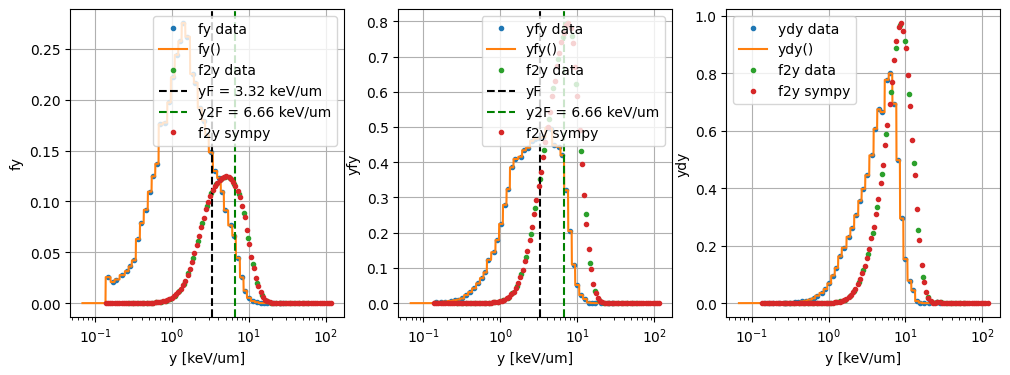

In [60]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
ax[0].plot(spectrum_clipped.y, spectrum_clipped.fy, ".", label="fy data")
ax[0].plot(xvalues, values_fy, label="fy()")
ax[0].plot(f2_spectrum.y, f2_spectrum.fy, ".", label="f2y data")
ax[0].axvline(
    spectrum_clipped.yF,
    color="k",
    linestyle="--",
    label=f"yF = {spectrum_clipped.yF:.2f} keV/um",
)
ax[0].axvline(
    f2_spectrum.yF,
    color="g",
    linestyle="--",
    label=f"y2F = {f2_spectrum.yF:.2f} keV/um",
)
ax[0].plot(f2_spectrum_sympy.y, f2_spectrum_sympy.fy, ".", label="f2y sympy")
ax[0].set_ylabel("fy")
ax[1].plot(spectrum_clipped.y, spectrum_clipped.yfy, ".", label="yfy data")
ax[1].plot(xvalues, values_yfy, label="yfy()")
ax[1].plot(f2_spectrum.y, f2_spectrum.yfy, ".", label="f2y data")
ax[1].axvline(spectrum_clipped.yF, color="k", linestyle="--", label="yF")
ax[1].axvline(
    f2_spectrum.yF,
    color="g",
    linestyle="--",
    label=f"y2F = {f2_spectrum.yF:.2f} keV/um",
)
ax[1].plot(f2_spectrum_sympy.y, f2_spectrum_sympy.yfy, ".", label="f2y sympy")
ax[1].set_ylabel("yfy")
ax[2].plot(spectrum_clipped.y, spectrum_clipped.ydy, ".", label="ydy data")
ax[2].plot(xvalues, values_ydy, label="ydy()")
ax[2].plot(f2_spectrum.y, f2_spectrum.ydy, ".", label="f2y data")
ax[2].plot(f2_spectrum_sympy.y, f2_spectrum_sympy.ydy, ".", label="f2y sympy")
ax[2].set_ylabel("ydy")
for a in ax:
    a.set_xscale("log")
    # a.set_yscale('log')
    a.grid()
    a.set_xlabel("y [keV/um]")
    a.legend()
#    a.set_xlim(10, 20)